# DenseNet 
Todo: Discussion

In [1]:
import os
import pathlib
from glob import glob
from typing import Union
import pandas as pd
import warnings

import tensorflow as tf
from bcd.model.repo import ModelRepo
from bcd.model.factory import DenseNetFactory
from bcd.model.transfer import FineTuner
from bcd.model.callback import Historian
pd.set_option('display.max_rows',999)


## Configuration

In [2]:
# Data params
batch_size = 32
input_shape = (224,224,3)
output_shape = 1
train_dir_10 = pathlib.Path("data/image/1_final/training_10/training/").with_suffix('')
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')

# Training Params
initial_epochs = 100  # Number of epochs to train for feature extraction
fine_tune_epochs = 50  # Number of epochs for each fine tune session
initial_learning_rate = 0.0001  # Base learning rate for the Adam optimizer 
loss = "binary_crossentropy"
activation = "sigmoid"

# Early stop callback 
min_delta = 0.0001
monitor = "val_loss"  # Monitor validation loss for early stopping
patience = 3  # The number of consecutive epochs for which lack of improvement is tolerated 
restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.


# ModelCheckpoint Callback parameters
location = "models/"
mode = "auto"
save_weights_only = False
save_best_only = True
save_freq = "epoch"
verbose = 1

# Historian parameters
historian_filepath = "models/densenet/densenet_history.pkl"

# Model Parameters
name = "densenet"
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model_factory = DenseNetFactory
force = False  # Whether to retrain if the model and weights already exist from a prior training session.
base_model_layer = 5 # Layer of the DenseNet base model

## Dependencies
Several dependencies will be used throughout this notebook, including:
- Early Stop Callback
- Model Repository
- DenseNet Model Factory
- Historian Callback

We'll make those objects available here.

In [3]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                       min_delta=min_delta,
                                                       patience=patience, 
                                                       restore_best_weights=restore_best_weights)
repo = ModelRepo(location=location)
factory = model_factory()
historian = Historian(name=name)

## Load Data

In [4]:
# Training DataSet (10%)
train_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.
Found 649 files belonging to 2 classes.


## Feature Extraction
If the model already exists, obtain it from the repository. Otherwise, create the model and perform feature extraction.

In [5]:
stage = "feature_extraction"
if force or not repo.exists(name=name, stage=stage):
    model = factory.create(input_shape=input_shape, 
                            output_shape=output_shape, 
                            learning_rate=initial_learning_rate, 
                            trainable=False, 
                            loss=loss, 
                            activation=activation, 
                            metrics=metrics)
    # Delete existing checkpoints
    repo.remove(name=name, stage=stage)
    # Obtain a checkpoint callback from the model repository 
    checkpoint_callback = repo.create_callback(name=name, stage=stage)
    # Set the session on the historian to 0 for feature extraction
    historian.on_session_begin(session=0)
    # Fit the model 
    history = model.fit(train_ds_10, epochs=initial_epochs, validation_data=val_ds_10, callbacks=[checkpoint_callback, early_stop_callback, historian])        
    # Visualize the learning curves.
    historian.plot_learning_curves()
    # Print summary of history
    historian.summary
else:
    model = repo.get(name=name, stage=stage)
    historian = historian.load(historian_filepath)


    

INFO:ModelRepo:Loaded densenet_feature_extraction model from the repository.


As expected, only the 1921 parameters in the output layer are trainable. The DenseNet model occupies the 5th layer in our overall model. This will be relevant at the fine-tuning stage as we target layers in the DenseNet model to thaw.

Let's create a checkpoint callback and fit the model with early stopping.

Excellent. We can now move on to the fine tuning stage.

## Fine Tuning

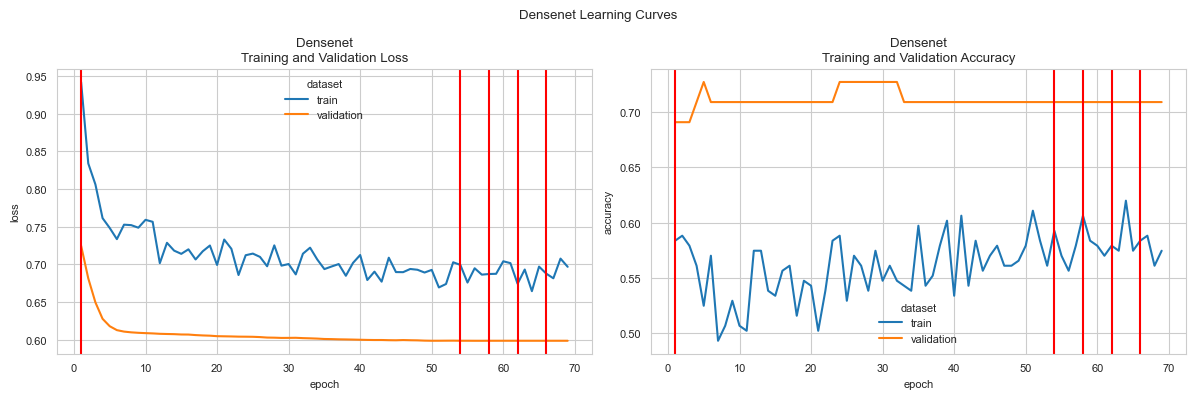

In [6]:
historian.plot_learning_curves()